# Задание 13-16: Рекуррентные нейронные сети
*Выполнено студенткой группы ИММО-01-25 Чан Минь Ханг*

Выполнить исследование и сравнительный анализ возможностей RNN, LSTM и GRU на примере предлагаемого кода: https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb

Работаем с TensorFlow! Например, 1.15.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/Colab Notebooks

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# get_ipython().run_line_magic('matplotlib', 'inline')

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, SimpleRNN, Activation
from keras.callbacks import EarlyStopping, History
from keras import backend as K

import gc

import time
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')


In [3]:
BOLD = '\033[1m'
END = '\033[0m'

Выполнить работу по варианту, соответствующему номеру с id
авиационного двигателя в наборе данных.

1. Сравнить полученные нейронные сети по Accuracy, Precision, Recall, F1, Loss на train и test. Выполнить несколько запусков программы с разными seed. Выбрать лучший вариант.
2. Выполнить исследования на примере фрагмента кода с заменой LSTM на RNN и GRU. Изучить и описать назначение используемых методов и параметров.
3. Исследовать, как определяется число параметров Param в каждом слое.
4. Изучить и описать назначение используемых методов и параметров.
5. Вывести графические зависимости для Loss и Accuracy на train и val (на обучающей и валидационной подвыборках).
6. Оценить время разработки классификаторов с CPU.
7. Оценить время разработки классификаторов с GPU (в Google Colab).

## Загрузка данных

In [4]:
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3',
                    's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10',
                    's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [5]:
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3',
                   's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10',
                   's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
test_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [6]:
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df

,0
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


## Предобработка данных

In [7]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.000000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.002770
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.005540
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.008310
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.011080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,0.477011,0.250000,0.0,0.0,0.686747,0.587312,0.782917,0.0,...,0.0,0.750000,0.0,0.0,0.271318,0.109500,4,1,2,0.540166
20627,100,197,0.408046,0.083333,0.0,0.0,0.701807,0.729453,0.866475,0.0,...,0.0,0.583333,0.0,0.0,0.124031,0.366197,3,1,2,0.542936
20628,100,198,0.522989,0.500000,0.0,0.0,0.665663,0.684979,0.775321,0.0,...,0.0,0.833333,0.0,0.0,0.232558,0.053991,2,1,2,0.545706
20629,100,199,0.436782,0.750000,0.0,0.0,0.608434,0.746021,0.747468,0.0,...,0.0,0.583333,0.0,0.0,0.116279,0.234466,1,1,2,0.548476


In [8]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.000000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.002770,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.005540,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.008310,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.011080,138,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.781609,0.500000,0.0,0.0,0.611446,0.619359,0.566172,0.0,...,0.0,0.500000,0.0,0.0,0.395349,0.418669,0.534626,24,1,1
13092,100,195,0.436782,0.416667,0.0,0.0,0.605422,0.537388,0.671843,0.0,...,0.0,0.583333,0.0,0.0,0.333333,0.528721,0.537396,23,1,1
13093,100,196,0.465517,0.250000,0.0,0.0,0.671687,0.482014,0.414754,0.0,...,0.0,0.583333,0.0,0.0,0.372093,0.429301,0.540166,22,1,1
13094,100,197,0.281609,0.583333,0.0,0.0,0.617470,0.522128,0.626435,0.0,...,0.0,0.583333,0.0,0.0,0.403101,0.518779,0.542936,21,1,1


In [9]:
train19 = train_df[train_df['id'] == 19]
train19

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
3776,19,1,0.758621,0.500000,0.0,0.0,0.403614,0.413124,0.486833,0.0,...,0.0,0.333333,0.0,0.0,0.480620,0.486882,157,0,0,0.000000
3777,19,2,0.442529,0.583333,0.0,0.0,0.484940,0.364726,0.485989,0.0,...,0.0,0.333333,0.0,0.0,0.534884,0.537697,156,0,0,0.002770
3778,19,3,0.442529,0.833333,0.0,0.0,0.650602,0.355134,0.427245,0.0,...,0.0,0.333333,0.0,0.0,0.426357,0.432063,155,0,0,0.005540
3779,19,4,0.580460,0.666667,0.0,0.0,0.397590,0.433617,0.504389,0.0,...,0.0,0.416667,0.0,0.0,0.519380,0.526098,154,0,0,0.008310
3780,19,5,0.471264,0.166667,0.0,0.0,0.361446,0.372575,0.428596,0.0,...,0.0,0.416667,0.0,0.0,0.503876,0.494615,153,0,0,0.011080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3929,19,154,0.793103,0.750000,0.0,0.0,0.837349,0.649880,0.750844,0.0,...,0.0,0.750000,0.0,0.0,0.317829,0.210991,4,1,2,0.423823
3930,19,155,0.609195,0.500000,0.0,0.0,0.515060,0.674297,0.869851,0.0,...,0.0,0.583333,0.0,0.0,0.069767,0.219276,3,1,2,0.426593
3931,19,156,0.333333,0.333333,0.0,0.0,0.671687,0.656856,0.813639,0.0,...,0.0,0.666667,0.0,0.0,0.255814,0.264568,2,1,2,0.429363
3932,19,157,0.649425,0.500000,0.0,0.0,0.668675,0.574232,0.755064,0.0,...,0.0,0.583333,0.0,0.0,0.015504,0.250759,1,1,2,0.432133


In [10]:
test19 = test_df[test_df['id'] == 19]
test19

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
2116,19,1,0.603448,0.416667,0.0,0.0,0.304217,0.466100,0.272957,0.0,...,0.0,0.250000,0.0,0.0,0.682171,0.793703,0.000000,221,0,0
2117,19,2,0.517241,0.333333,0.0,0.0,0.310241,0.232396,0.325625,0.0,...,0.0,0.333333,0.0,0.0,0.651163,0.638221,0.002770,220,0,0
2118,19,3,0.488506,0.583333,0.0,0.0,0.340361,0.476782,0.214720,0.0,...,0.0,0.333333,0.0,0.0,0.782946,0.696217,0.005540,219,0,0
2119,19,4,0.304598,0.416667,0.0,0.0,0.186747,0.334641,0.391627,0.0,...,0.0,0.416667,0.0,0.0,0.705426,0.535487,0.008310,218,0,0
2120,19,5,0.534483,0.750000,0.0,0.0,0.216867,0.219533,0.125591,0.0,...,0.0,0.250000,0.0,0.0,0.651163,0.612262,0.011080,217,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2246,19,131,0.706897,0.416667,0.0,0.0,0.295181,0.258993,0.338454,0.0,...,0.0,0.333333,0.0,0.0,0.604651,0.554681,0.360111,91,0,0
2247,19,132,0.471264,1.000000,0.0,0.0,0.382530,0.418138,0.465901,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.612676,0.362881,90,0,0
2248,19,133,0.511494,1.000000,0.0,0.0,0.424699,0.335731,0.315159,0.0,...,0.0,0.500000,0.0,0.0,0.573643,0.555924,0.365651,89,0,0
2249,19,134,0.729885,0.500000,0.0,0.0,0.316265,0.455853,0.301823,0.0,...,0.0,0.333333,0.0,0.0,0.589147,0.661834,0.368421,88,0,0


## Подготовка последовательностей

In [11]:
sequence_length = 50

# Определение столбцов для последовательностей
sensor_cols = ['s' + str(i) for i in range(1, 22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

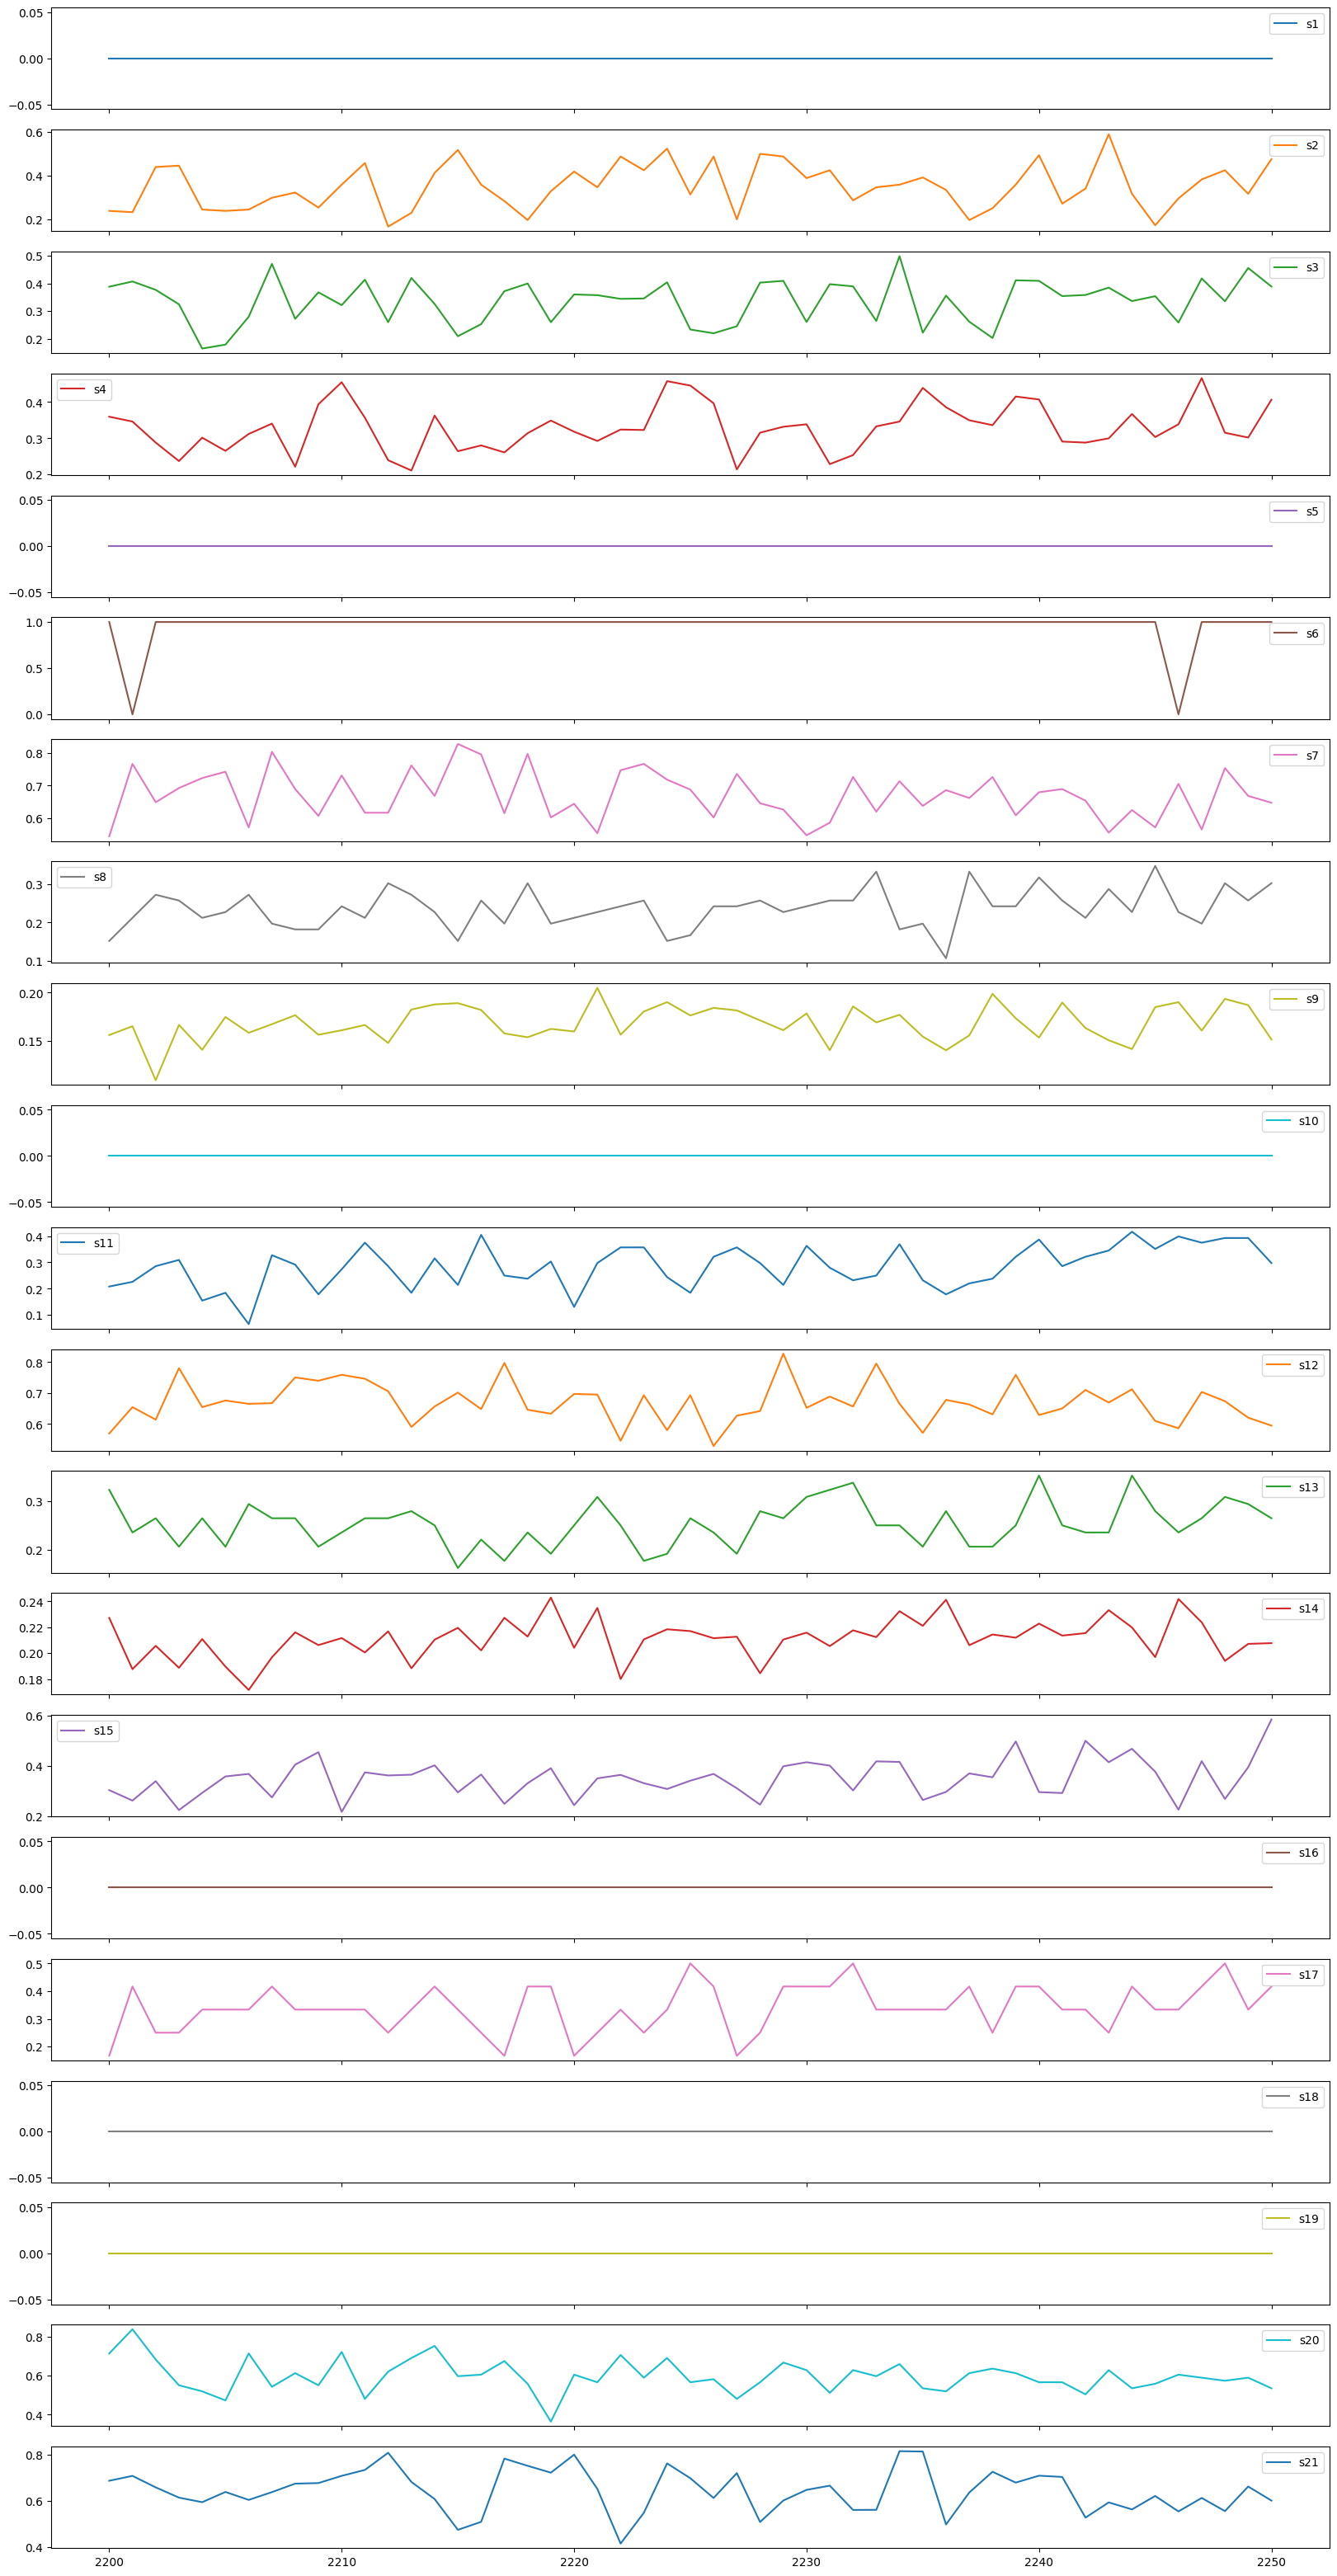

In [12]:
engine_df = test19
engine_50cycleWindow = engine_df[engine_df['RUL'] <= engine_df['RUL'].min() + 50][sensor_cols]
ax = engine_50cycleWindow.plot(subplots=True, sharex=True, figsize=(20,40))

In [14]:
# function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    sequences = []
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        sequences.append(data_array[start:stop, :])
    return sequences

seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols))
           for id in train_df['id'].unique())
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique()
                       if len(test_df[test_df['id']==id]) >= sequence_length]
seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

X_train = seq_array
X_test = seq_array_test_last

# X_train = np.array(gen_sequence(train19, sequence_length, sequence_cols))
# X_test = np.array(gen_sequence(test19, sequence_length, sequence_cols))

print(f"Размерность X_train: {X_train.shape}")
print(f"Размерность X_test: {X_test.shape}")

Размерность X_train: (15631, 50, 25)
Размерность X_test: (93, 50, 25)


In [15]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    # return data_array[seq_length:num_elements, :]
    return data_array[seq_length:num_elements].reshape(-1, 1)

label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1'])
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)

y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

y_train = label_array
y_test = label_array_test_last

# y_train = gen_labels(train19, sequence_length, 'label1')
# y_test = gen_labels(test19, sequence_length, 'label1')

print(f"Размерность y_train: {y_train.shape}")
print(f"Размерность y_test: {y_test.shape}")

Размерность y_train: (15631, 1)
Размерность y_test: (93, 1)


In [16]:
# Параметры моделей
nb_features = X_train.shape[2]
nb_out = y_train.shape[1]

In [17]:
print(f"Длина последовательности: {sequence_length}")
print(f"Количество признаков: {nb_features}")
print(f"Размер выхода: {nb_out}")
print(f"Тренировочные данные: {X_train.shape[0]} последовательностей")
print(f"Тестовые данные: {X_test.shape[0]} последовательностей")

Длина последовательности: 50
Количество признаков: 25
Размер выхода: 1
Тренировочные данные: 15631 последовательностей
Тестовые данные: 93 последовательностей


## Обучение моделей

In [18]:
def create_model(model_type, sequence_length, nb_features, nb_out):
    model = Sequential()

    match model_type:
        case "LSTM":
            layer1 = LSTM(
                input_shape=(sequence_length, nb_features),
                units=100, return_sequences=True)
            layer2 = LSTM(
                units=50, return_sequences=False)
        case "GRU":
            layer1 = GRU(
                input_shape=(sequence_length, nb_features),
                units=100, return_sequences=True)
            layer2 = GRU(
                units=50, return_sequences=False)
        case "RNN":
            layer1 = SimpleRNN(
                input_shape=(sequence_length, nb_features),
                units=100, return_sequences=True)
            layer2 = SimpleRNN(
                units=50, return_sequences=False)

    # Первый слой
    model.add(layer1)
    model.add(Dropout(0.2))

    # Второй слой
    model.add(layer2)
    model.add(Dropout(0.2))

    # Выходной слой
    model.add(Dense(units=nb_out, activation='sigmoid'))

    # Компиляция модели
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

Sequential() — класс в Keras, позволяющий создавать модели слоёв, которые последовательно соединены друг с другом (feedforward). Подходит для большинства стандартных архитектур.

1. LSTM (Long Short-Term Memory) — тип рекуррентного слоя, способный запоминать долгосрочные зависимости благодаря встроенным механизмам gating.

2. GRU (Gated Recurrent Unit) — упрощённая версия LSTM, имеет меньше параметров и быстрее обучается, но сохраняет способность улавливать долгосрочные зависимости.

3. SimpleRNN — простая рекуррентная нейронная сеть, не имеет механизма ворот, склонна к проблеме затухающего градиента.


- input_shape=(sequence_length, nb_features) — определяет форму входных данных: длина последовательности и количество признаков.

- units=100 / units=50 — количество нейронов в слое LSTM, определяет размер скрытого состояния.

- return_sequences=True — возвращает все скрытые состояния для каждого временного шага, что необходимо для стыковки с последующим рекуррентным слоем.

- return_sequences=False — возвращает только последнее скрытое состояние.

Dropout(rate=0.2) — метод регуляризации, случайно отключает 20% нейронов на каждом шаге обучения, чтобы предотвратить переобучение.

Dense — полносвязный слой.

- units=nb_out — количество выходных нейронов (1 для бинарной классификации).

- activation='sigmoid' — сигмоидальная функция активации, преобразует выход в вероятность от 0 до 1.

compile() — конфигурирует модель для обучения.

- loss='binary_crossentropy' — функция потерь для бинарной классификации.

- optimizer='adam' — алгоритм оптимизации Adam (адаптивная оценка моментов).

- metrics=['accuracy'] — метрика, которая будет отслеживаться во время обучения и валидации.






In [19]:
def evaluate_model(model, X, y):
    results = model.evaluate(X, y, verbose=0)
    metrics = {
        'loss': results[0],
        'accuracy': results[1]
    }

    y_pred = (model.predict(X, verbose=0) > 0.5).astype("int32")

    metrics['precision'] = precision_score(y, y_pred, zero_division=0)
    metrics['recall'] = recall_score(y, y_pred, zero_division=0)
    metrics['f1'] = f1_score(y, y_pred, zero_division=0)
    metrics['confusion_matrix'] = confusion_matrix(y, y_pred)
    return metrics


def train_model(model_type, X_train, y_train, X_test, y_test,
                sequence_length, nb_features, nb_out, seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model = create_model(model_type, sequence_length, nb_features, nb_out)

    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=200,
        validation_split=0.05,
        verbose=1,
        callbacks=[EarlyStopping(monitor='val_loss',
                                 min_delta=0,
                                 patience=0,
                                 verbose=0,
                                 mode='auto',
                                 restore_best_weights=True)]
    )
    training_time = time.time() - start_time

    results = {
        'model_type': model_type,
        'seed' : seed,
        'model': model,
        'training_time': training_time,
        'train_metrics': evaluate_model(model, X_train, y_train),
        'test_metrics': evaluate_model(model, X_test, y_test),
        'history': history.history
    }
    return results


model_types = ['LSTM', 'GRU', 'RNN']
def compare_models(model_types, X_train, y_train, X_test, y_test,
                   sequence_length, nb_features, nb_out, seeds):
    keras.backend.clear_session()

    all_results = {}

    for model_type in model_types:
        print(BOLD + f"\nМОДЕЛь: {model_type}" + END)
        model_results = []

        for seed in seeds:
            print(f"\nSeed = {seed}")

            results = train_model(
                model_type, X_train, y_train, X_test, y_test,
                sequence_length, nb_features, nb_out, seed=seed
            )
            model_results.append(results)

        all_results[model_type] = model_results

    return all_results

model.fit(): Обучение модели на тренировочных данных.

- X_train, y_train: Входные данные и метки для обучения.

- epochs=10: Количество полных проходов по обучающему набору данных.

- batch_size=200: Количество образцов, обрабатываемых перед обновлением весов.
 (Больше batch_size → стабильнее градиенты, но больше памяти.)

- validation_split=0.05: Доля данных (5%), используемых для валидации в процессе обучения. (Помогает отслеживать переобучение.)

- verbose=1: Уровень детализации вывода (1 — прогресс-бар).

- callbacks=[EarlyStopping(...)]: Коллбэки для контроля процесса обучения.


EarlyStopping(): Автоматическая остановка обучения при отсутствии улучшений.

- monitor='val_loss': Метрика для отслеживания (потери на валидации).

- min_delta=0: Минимальное изменение для улучшения (0 — любое улучшение считается).

- patience=0: Количество эпох без улучшений перед остановкой (0 — остановка сразу при ухудшении).

- verbose=0: Без вывода сообщений об остановке.

- mode='auto': Автоматический выбор направления улучшения (минимизация val_loss).

- restore_best_weights=True: Восстановление весов из лучшей эпохи после остановки.



In [20]:
all_results = compare_models(['LSTM', 'GRU', 'RNN'],
                             X_train, y_train, X_test, y_test,
                             sequence_length, nb_features, nb_out,
                             seeds=[1234, 42, 125])


МОДЕЛь: LSTM

Seed = 1234
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 245ms/step - accuracy: 0.8549 - loss: 0.3588 - val_accuracy: 0.9744 - val_loss: 0.0743
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 258ms/step - accuracy: 0.9546 - loss: 0.1061 - val_accuracy: 0.9655 - val_loss: 0.0770

Seed = 42
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 365ms/step - accuracy: 0.8572 - loss: 0.3474 - val_accuracy: 0.9463 - val_loss: 0.1219
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.9513 - loss: 0.1233 - val_accuracy: 0.9757 - val_loss: 0.0603
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 252ms/step - accuracy: 0.9643 - loss: 0.0868 - val_accuracy: 0.9514 - val_loss: 0.0875

Seed = 125
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 248ms/step - accuracy: 0.8657 - loss: 0.3433 - val_accuracy: 0.9731 - val_loss: 0.0779
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 247ms/step - accuracy: 0.9589 - loss: 0.0975 - val_accuracy: 0.9540 - val_loss: 0.1161

МОДЕЛь: GRU

Seed = 1234
Epoch 1/10
75/75 ━━━━

## Сравнение результатов

In [21]:
results_list = []

for model_type, model_results in all_results.items():
    for result in model_results:
        row = {
            'Model': model_type,
            'Seed': result['seed'],
            'Training_Time': result['training_time']
        }

        train_metrics = result['train_metrics']
        row.update({
            'Train_Loss': train_metrics['loss'],
            'Train_Accuracy': train_metrics['accuracy'],
            'Train_Precision': train_metrics['precision'],
            'Train_Recall': train_metrics['recall'],
            'Train_F1': train_metrics['f1']
        })

        test_metrics = result['test_metrics']
        row.update({
            'Test_Loss': test_metrics['loss'],
            'Test_Accuracy': test_metrics['accuracy'],
            'Test_Precision': test_metrics['precision'],
            'Test_Recall': test_metrics['recall'],
            'Test_F1': test_metrics['f1']
        })

        row.update({
            'Val_Loss': test_metrics['loss'],
            'Val_Accuracy': test_metrics['accuracy']
        })

        results_list.append(row)

results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(['Model', 'Seed']).reset_index(drop=True)

results_df

,Model,Seed,Training_Time,Train_Loss,Train_Accuracy,Train_Precision,Train_Recall,Train_F1,Test_Loss,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Val_Loss,Val_Accuracy
0,GRU,42,192.165205,0.047822,0.981575,0.967420,0.938710,0.952849,0.046300,0.978495,0.960000,0.96,0.960000,0.046300,0.978495
1,GRU,125,46.935230,0.145698,0.938967,0.895066,0.784194,0.835970,0.268374,0.892473,0.941176,0.64,0.761905,0.268374,0.892473
2,GRU,1234,128.270836,0.088911,0.963598,0.865013,0.967419,0.913355,0.070745,0.989247,0.961538,1.00,0.980392,0.070745,0.989247
3,LSTM,42,68.746557,0.073777,0.970571,0.938538,0.911290,0.924714,0.102584,0.935484,0.952381,0.80,0.869565,0.102584,0.935484
4,LSTM,125,41.595731,0.097156,0.961871,0.928181,0.875484,0.901062,0.137220,0.935484,1.000000,0.76,0.863636,0.137220,0.935484
5,LSTM,1234,41.318918,0.095798,0.965069,0.924817,0.896774,0.910580,0.117621,0.967742,0.958333,0.92,0.938776,0.117621,0.967742
6,RNN,42,22.095070,0.112047,0.953682,0.929191,0.829677,0.876619,0.156191,0.935484,0.952381,0.80,0.869565,0.156191,0.935484
7,RNN,125,42.699306,0.079742,0.972107,0.978792,0.878387,0.925876,0.156672,0.946237,0.954545,0.84,0.893617,0.156672,0.946237
8,RNN,1234,24.482273,0.091811,0.962894,0.885793,0.933226,0.908891,0.078966,0.967742,0.923077,0.96,0.941176,0.078966,0.967742


In [22]:
def best_by_metric(df, metric, higher_is_better=True):
    if higher_is_better:
        best_idx = df[metric].idxmax()
    else:
        best_idx = df[metric].idxmin()

    best_value = df.loc[best_idx, metric]
    best_row = df.loc[best_idx]

    return {
        'Metric': metric,
        'Value': best_value,
        'Model': best_row['Model'],
        'Seed': best_row['Seed']
    }


test_metrics = ['Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1']
train_metrics = ['Train_Accuracy', 'Train_Precision', 'Train_Recall', 'Train_F1']

best_results = []
for metric in test_metrics:
    best_result = best_by_metric(results_df, metric)
    best_results.append(best_result)
for metric in train_metrics:
    best_result = best_by_metric(results_df, metric)
    best_results.append(best_result)

pd.DataFrame(best_results)

,Metric,Value,Model,Seed
0,Test_Accuracy,0.989247,GRU,1234
1,Test_Precision,1.000000,LSTM,125
2,Test_Recall,1.000000,GRU,1234
3,Test_F1,0.980392,GRU,1234
4,Train_Accuracy,0.981575,GRU,42
5,Train_Precision,0.978792,RNN,125
6,Train_Recall,0.967419,GRU,1234
7,Train_F1,0.952849,GRU,42


In [23]:
best_models = {}
for model_type, results in all_results.items():
    best_result = max(results, key=lambda x: x['test_metrics']['f1'])
    best_models[model_type] = best_result

comparison_data = []
for model_type, result in best_models.items():
    row = {
        'Model': model_type,
        'Best Seed': result['seed'],
        'Train Loss': f"{result['train_metrics']['loss']:.4f}",
        'Test Loss': f"{result['test_metrics']['loss']:.4f}",
        'Train Accuracy': f"{result['train_metrics']['accuracy']:.4f}",
        'Test Accuracy': f"{result['test_metrics']['accuracy']:.4f}",
        'Test Precision': f"{result['test_metrics']['precision']:.4f}",
        'Test Recall': f"{result['test_metrics']['recall']:.4f}",
        'Test F1-Score': f"{result['test_metrics']['f1']:.4f}",
        'Training Time (s)': f"{result['training_time']:.2f}"
    }
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
comparison_df.set_index('Model', inplace=True)

comparison_df.sort_values(['Model'])

,Best Seed,Train Loss,Test Loss,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1-Score,Training Time (s)
Model,,,,,,,,,
GRU,1234,0.0889,0.0707,0.9636,0.9892,0.9615,1.0000,0.9804,128.27
LSTM,1234,0.0958,0.1176,0.9651,0.9677,0.9583,0.9200,0.9388,41.32
RNN,1234,0.0918,0.0790,0.9629,0.9677,0.9231,0.9600,0.9412,24.48


## Расчет параметров Param в каждом слое

In [24]:
def explain_layers(model):
    print("")

    for i, layer in enumerate(model.layers):
        layer_type = layer.__class__.__name__

        if layer_type in ['LSTM', 'GRU', 'SimpleRNN']:
            input_dim = nb_features if i == 0 else model.layers[i-2].units
            units = layer.units

            print(f"Слой {i+1} ({layer_type}):")
            print(f"\tВходной размер (input_dim): {input_dim}")
            print(f"\tКоличество юнитов (units): {units}")
            if layer_type == 'LSTM':
                params = 4 * ((input_dim + units) * units + units)
                print(f"\tПараметры: 4 * (({input_dim} + {units}) * {units} + {units}) = {params}")
                print(f"\tФормула: 4 * [(input_dim + units) * units + units]")
                print(f"\tОбъяснение: 4 соответствует входному, forget, выходному gate и gate кандидата")
            elif layer_type == 'GRU':
                params = 3 * ((input_dim + units) * units + units)
                print(f"\tПараметры: 3 * (({input_dim} + {units}) * {units} + {units}) = {params}")
                print(f"\tФормула: 3 * [(input_dim + units) * units + units]")
                print(f"\tОбъяснение: 3 соответствует reset gate, update gate и gate кандидата")
            elif layer_type == 'SimpleRNN':
                params = (input_dim + units) * units + units
                print(f"\tПараметры: ({input_dim} + {units}) * {units} + {units} = {params}")
                print(f"\tФормула: (input_dim + units) * units + units")

        elif layer_type == 'Dense':
            input_dim = model.layers[i-2].units if i >= 2 else 50
            units = layer.units
            params = input_dim * units + units
            print(f"Выходной слой ({layer_type}):")
            print(f"\tВходной размер (input_dim): {input_dim}")
            print(f"\tКоличество юнитов (units): {units}")
            print(f"\tПараметры: {input_dim} * {units} + {units} = {params}")
            print(f"\tФормула: input_dim * units + units")

In [25]:
for model_type, result in best_models.items():
    print(BOLD + f"\n\n{model_type} с seed={result['seed']}" + END)
    model = result['model']
    model.summary()
    explain_layers(model)



LSTM с seed=1234


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 100)        │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,955 (945.14 KB)

 Trainable params: 80,651 (315.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 161,304 (630.10 KB)


Слой 1 (LSTM):
	Входной размер (input_dim): 25
	Количество юнитов (units): 100
	Параметры: 4 * ((25 + 100) * 100 + 100) = 50400
	Формула: 4 * [(input_dim + units) * units + units]
	Объяснение: 4 соответствует входному, forget, выходному gate и gate кандидата
Слой 3 (LSTM):
	Входной размер (input_dim): 100
	Количество юнитов (units): 50
	Параметры: 4 * ((100 + 50) * 50 + 50) = 30200
	Формула: 4 * [(input_dim + units) * units + units]
	Объяснение: 4 соответствует входному, forget, выходному gate и gate кандидата
Выходной слой (Dense):
	Входной размер (input_dim): 50
	Количество юнитов (units): 1
	Параметры: 50 * 1 + 1 = 51
	Формула: input_dim * units + units


GRU с seed=1234


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50, 100)        │        38,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        22,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,855 (714.28 KB)

 Trainable params: 60,951 (238.09 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 121,904 (476.19 KB)


Слой 1 (GRU):
	Входной размер (input_dim): 25
	Количество юнитов (units): 100
	Параметры: 3 * ((25 + 100) * 100 + 100) = 37800
	Формула: 3 * [(input_dim + units) * units + units]
	Объяснение: 3 соответствует reset gate, update gate и gate кандидата
Слой 3 (GRU):
	Входной размер (input_dim): 100
	Количество юнитов (units): 50
	Параметры: 3 * ((100 + 50) * 50 + 50) = 22650
	Формула: 3 * [(input_dim + units) * units + units]
	Объяснение: 3 соответствует reset gate, update gate и gate кандидата
Выходной слой (Dense):
	Входной размер (input_dim): 50
	Количество юнитов (units): 1
	Параметры: 50 * 1 + 1 = 51
	Формула: input_dim * units + units


RNN с seed=1234


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50, 100)        │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,605 (236.74 KB)

 Trainable params: 20,201 (78.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,404 (157.83 KB)


Слой 1 (SimpleRNN):
	Входной размер (input_dim): 25
	Количество юнитов (units): 100
	Параметры: (25 + 100) * 100 + 100 = 12600
	Формула: (input_dim + units) * units + units
Слой 3 (SimpleRNN):
	Входной размер (input_dim): 100
	Количество юнитов (units): 50
	Параметры: (100 + 50) * 50 + 50 = 7550
	Формула: (input_dim + units) * units + units
Выходной слой (Dense):
	Входной размер (input_dim): 50
	Количество юнитов (units): 1
	Параметры: 50 * 1 + 1 = 51
	Формула: input_dim * units + units


## Визуализация

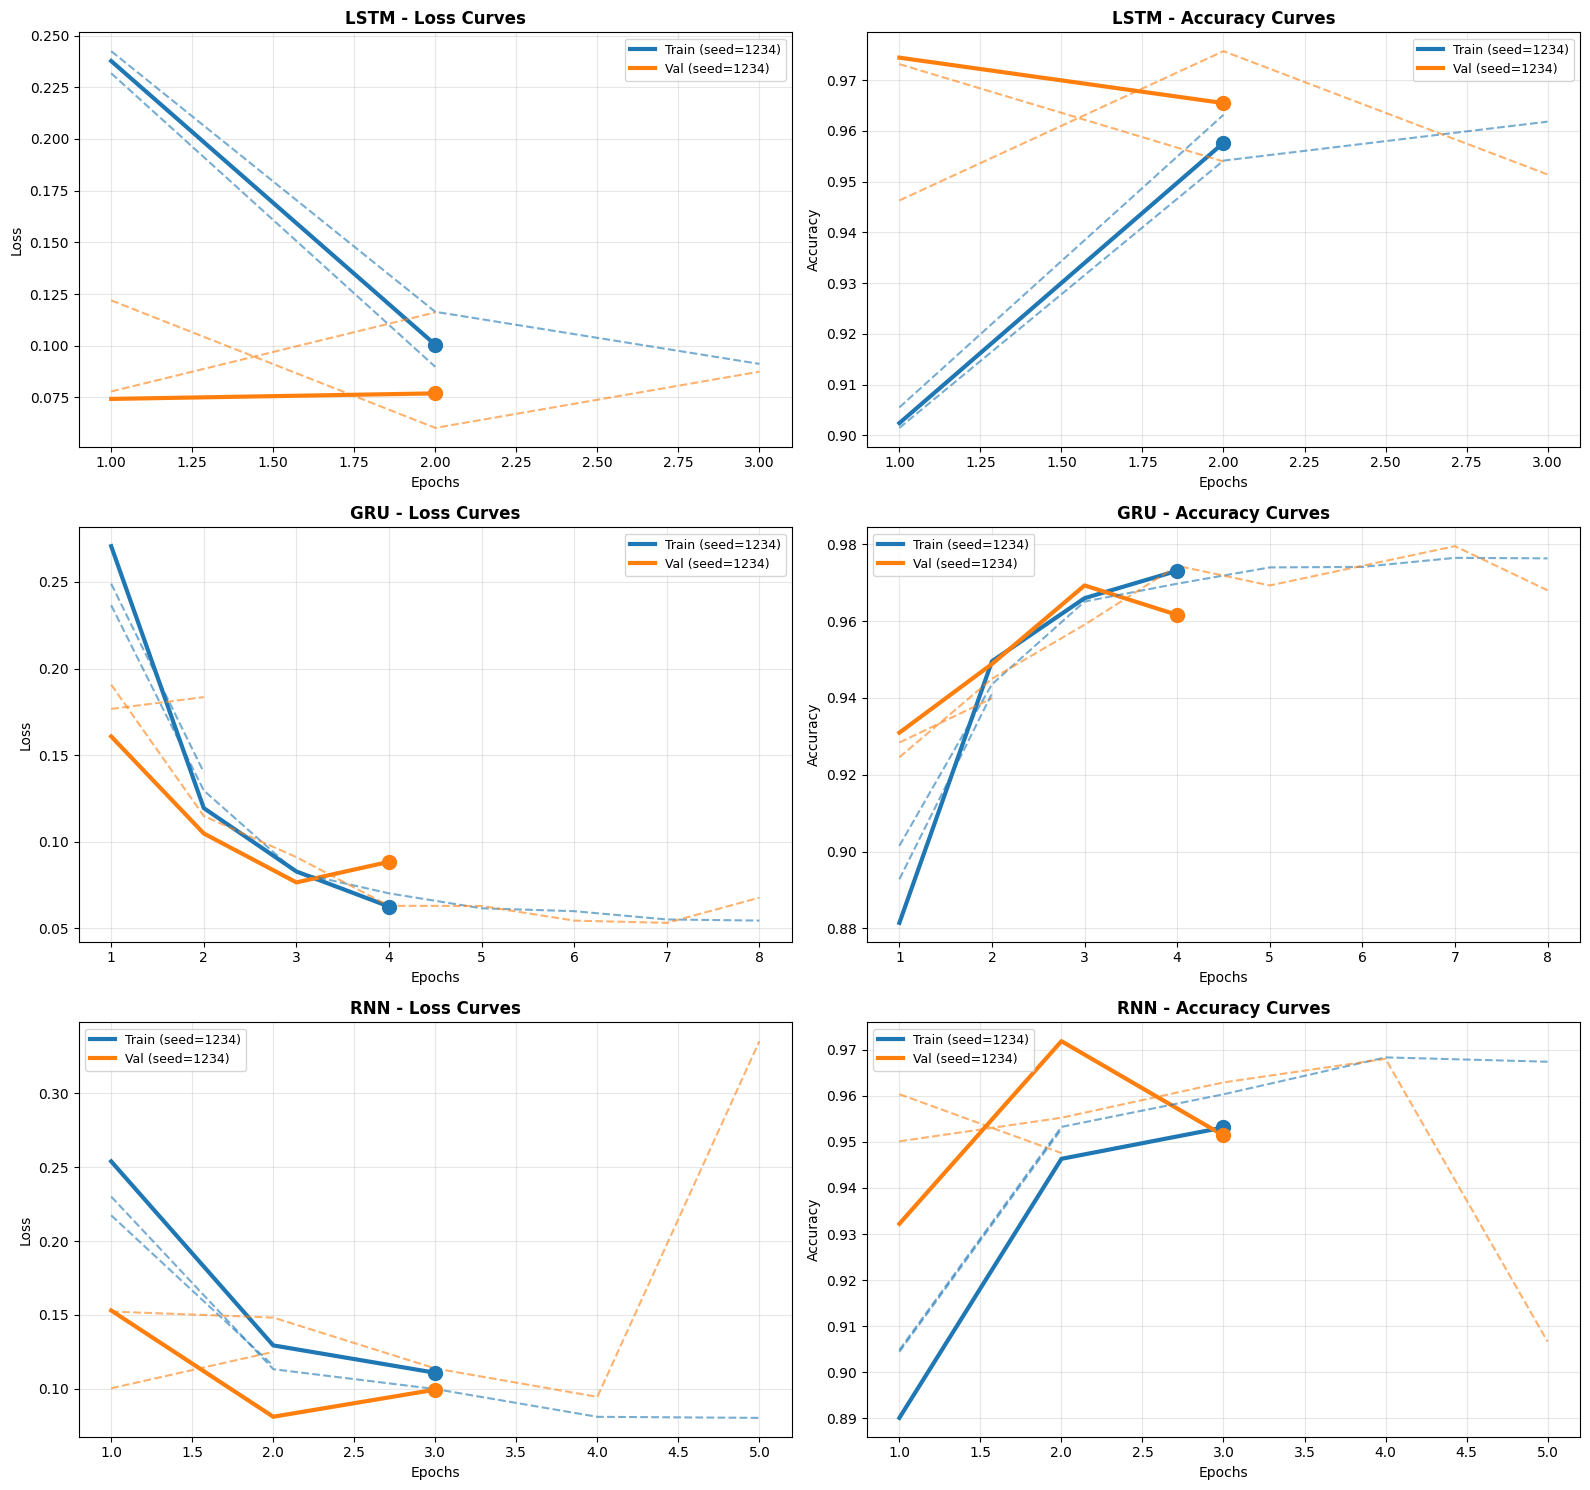

In [26]:
fig, axes = plt.subplots(3, 2, figsize=(16, 15))

model_colors = {'LSTM': '#1f77b4', 'GRU': '#2ca02c', 'RNN': '#d62728'}
curve_colors = {'train': '#1f77b4', 'val': '#ff7f0e'}

for model_idx, (model_type, results_list) in enumerate(all_results.items()):
    for seed_idx, result in enumerate(results_list):
        history = result['history']
        seed = result['seed']

        is_best = (best_models[model_type]['seed'] == seed)

        linewidth = 3 if is_best else 1.5
        alpha = 1.0 if is_best else 0.6
        linestyle = '-' if is_best else '--'

        # Loss кривые
        ax_loss = axes[model_idx, 0]
        epochs_loss = range(1, len(history['loss']) + 1)
        ax_loss.plot(epochs_loss, history['loss'],
                    color=curve_colors['train'],
                    linewidth=linewidth, alpha=alpha, linestyle=linestyle,
                    label=f'Train (seed={seed})' if is_best else "")
        ax_loss.plot(epochs_loss, history['val_loss'],
                    color=curve_colors['val'],
                    linewidth=linewidth, alpha=alpha, linestyle=linestyle,
                    label=f'Val (seed={seed})' if is_best else "")
        if is_best:
            ax_loss.scatter(epochs_loss[-1], history['loss'][-1],
                            color=curve_colors['train'], s=100, zorder=5)
            ax_loss.scatter(epochs_loss[-1], history['val_loss'][-1],
                            color=curve_colors['val'], s=100, zorder=5)
        ax_loss.set_xlabel('Epochs')
        ax_loss.set_ylabel('Loss')
        ax_loss.set_title(f'{model_type} - Loss Curves', fontweight='bold')
        ax_loss.grid(True, alpha=0.3)
        ax_loss.legend(fontsize=9)

        # Accuracy кривые
        ax_acc = axes[model_idx, 1]
        epochs_acc = range(1, len(history['accuracy']) + 1)
        ax_acc.plot(epochs_acc, history['accuracy'],
                    color=curve_colors['train'],
                    linewidth=linewidth, alpha=alpha, linestyle=linestyle,
                    label=f'Train (seed={seed})' if is_best else "")
        ax_acc.plot(epochs_acc, history['val_accuracy'],
                    color=curve_colors['val'],
                    linewidth=linewidth, alpha=alpha, linestyle=linestyle,
                    label=f'Val (seed={seed})' if is_best else "")
        if is_best:
            ax_acc.scatter(epochs_acc[-1], history['accuracy'][-1],
                           color=curve_colors['train'], s=100, zorder=5)
            ax_acc.scatter(epochs_acc[-1], history['val_accuracy'][-1],
                           color=curve_colors['val'], s=100, zorder=5)
        ax_acc.set_xlabel('Epochs')
        ax_acc.set_ylabel('Accuracy')
        ax_acc.set_title(f'{model_type} - Accuracy Curves', fontweight='bold')
        ax_acc.grid(True, alpha=0.3)
        ax_acc.legend(fontsize=9)
        # ax_acc.set_ylim([0.8, 1.0])

plt.tight_layout()
plt.show()

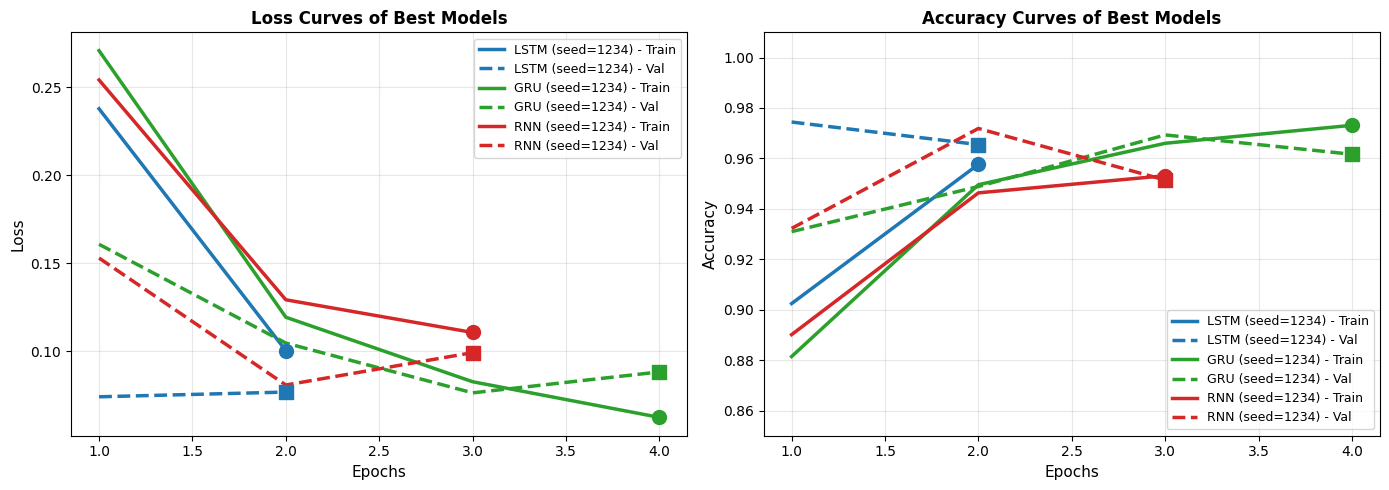

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = {'LSTM': '#1f77b4', 'GRU': '#2ca02c', 'RNN': '#d62728'}
line_styles = {'train': '-', 'val': '--'}

# 1. Loss кривые для лучших моделей
ax1 = axes[0]
for model_type, best_result in best_models.items():
    history = best_result['history']
    seed = best_result['seed']

    epochs = range(1, len(history['loss']) + 1)

    ax1.plot(epochs, history['loss'],
            color=colors[model_type],
            linewidth=2.5,
            linestyle=line_styles['train'],
            label=f'{model_type} (seed={seed}) - Train')

    ax1.plot(epochs, history['val_loss'],
            color=colors[model_type],
            linewidth=2.5,
            linestyle=line_styles['val'],
            label=f'{model_type} (seed={seed}) - Val')

    # Добавляем конечные точки
    ax1.scatter(epochs[-1], history['loss'][-1],
                color=colors[model_type], s=100, zorder=5)
    ax1.scatter(epochs[-1], history['val_loss'][-1],
                color=colors[model_type], s=100, zorder=5, marker='s')

ax1.set_xlabel('Epochs', fontsize=11)
ax1.set_ylabel('Loss', fontsize=11)
ax1.set_title('Loss Curves of Best Models', fontweight='bold')
ax1.legend(fontsize=9, loc='upper right')
ax1.grid(True, alpha=0.3)

# 2. Accuracy кривые для лучших моделей
ax2 = axes[1]
for model_type, best_result in best_models.items():
    history = best_result['history']
    seed = best_result['seed']

    epochs = range(1, len(history['accuracy']) + 1)

    ax2.plot(epochs, history['accuracy'],
            color=colors[model_type],
            linewidth=2.5,
            linestyle=line_styles['train'],
            label=f'{model_type} (seed={seed}) - Train')

    ax2.plot(epochs, history['val_accuracy'],
            color=colors[model_type],
            linewidth=2.5,
            linestyle=line_styles['val'],
            label=f'{model_type} (seed={seed}) - Val')

    # Добавляем конечные точки
    ax2.scatter(epochs[-1], history['accuracy'][-1],
                color=colors[model_type], s=100, zorder=5)
    ax2.scatter(epochs[-1], history['val_accuracy'][-1],
                color=colors[model_type], s=100, zorder=5, marker='s')

ax2.set_xlabel('Epochs', fontsize=11)
ax2.set_ylabel('Accuracy', fontsize=11)
ax2.set_title('Accuracy Curves of Best Models', fontweight='bold')
ax2.legend(fontsize=9, loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.85, 1.01])

plt.tight_layout()
plt.show()

## Оценка времени разработки классификаторов с CPU и GPU

In [28]:
def test_device(model_type, X_train, y_train, X_test, y_test,
                sequence_length, nb_features, nb_out, seed):
    keras.backend.clear_session()
    gc.collect()

    np.random.seed(seed)
    tf.random.set_seed(seed)

    model = create_model(model_type, sequence_length, nb_features, nb_out)

    start_time = time.time()

    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=200,
        validation_split=0.05,
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss',
                                 min_delta=0,
                                 patience=0,
                                 verbose=0,
                                 mode='auto',
                                 restore_best_weights=True)])

    training_time = time.time() - start_time

    return {
        'device': "GPU" if tf.test.is_gpu_available() else "CPU",
        'model_type': model_type,
        'seed': seed,
        'training_time': training_time
    }


print('GPU' if len(tf.config.list_physical_devices('GPU')) > 0 else 'CPU')
result = test_device('GRU', X_train, y_train, X_test, y_test,
                     sequence_length, nb_features, nb_out, 1234)

result

CPU


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


{'device': 'CPU',
 'model_type': 'GRU',
 'seed': 1234,
 'training_time': 87.62115573883057}

In [32]:
result_cpu = {'device': 'CPU',
              'model_type': 'GRU',
              'seed': 1234,
              'training_time': 87.62115573883057}

result_gpu = {'device': 'GPU',
              'model_type': 'GRU',
              'seed': 1234,
              'training_time': 7.78170919418335}

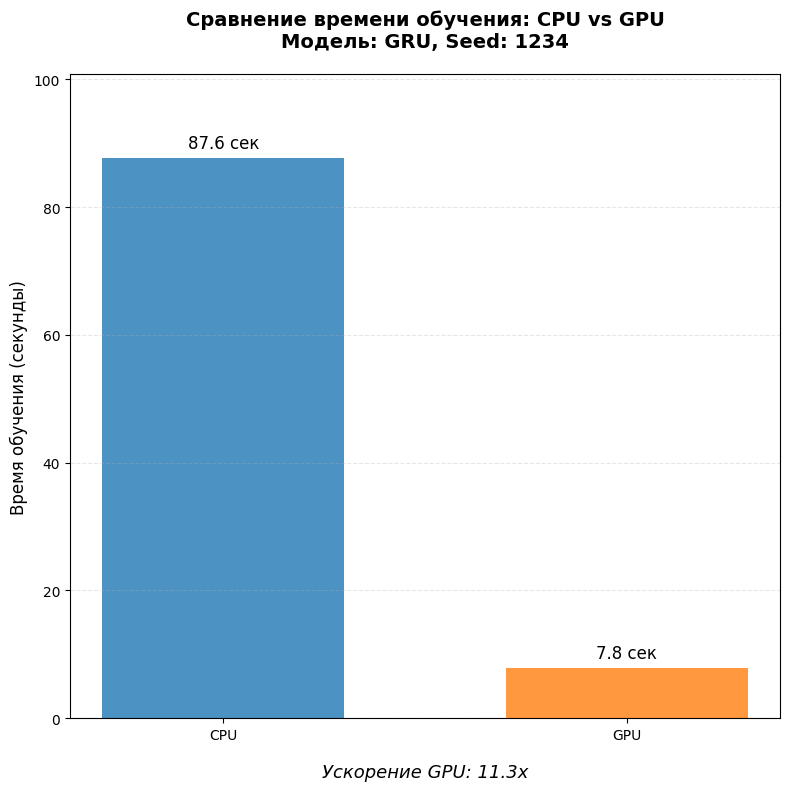

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))

devices = ['CPU', 'GPU']
times = [result_cpu['training_time'], result_gpu['training_time']]

bars = ax.bar(devices, times,
              color=['#1f77b4', '#ff7f0e'], alpha=0.8, width=0.6)

for i, (bar, time_val) in enumerate(zip(bars, times)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{time_val:.1f} сек',
            ha='center', va='bottom', fontsize=12)

ax.set_ylabel('Время обучения (секунды)', fontsize=12)
ax.set_ylim(0, max(times) * 1.15)

ax.set_title(f'Сравнение времени обучения: CPU vs GPU\n'
             f'Модель: {result_cpu['model_type']}, Seed: {result_cpu['seed']}',
             fontsize=14, fontweight='bold', pad=20)

ax.grid(True, axis='y', alpha=0.3, linestyle='--')

speedup = result_cpu['training_time'] / result_gpu['training_time']
ax.text(0.5, -max(times) * 0.08, f'Ускорение GPU: {speedup:.1f}x',
        ha='center', va='top', fontsize=13, style='italic')

plt.tight_layout()
plt.show()